In [59]:
import serial
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

baud_rate = 115200
mask_header = b'\xfa'
mask_tail = b'\xfe\xfe'
mask_serial_number = bytes(b'\x80\x00')

In [60]:
def int_from_bytes(xbytes: bytes) -> int:
    temp = bytearray(xbytes)
    temp.reverse()
    temp = int.from_bytes(temp, byteorder="big", signed=False)
    return temp

def bitwise_and_bytes(a, b):
    result_int = int.from_bytes(a, byteorder="big") & int.from_bytes(b, byteorder="big")
    return result_int.to_bytes(max(len(a), len(b)), byteorder="big")

def open_serial_port(port_number, baud_rate):
    serial_port = serial.Serial(port_number, baud_rate)
    return serial_port

In [61]:
ports = list(serial.tools.list_ports.comports())
ports = sorted(ports)
serial_port = None
for p in ports:
    # find serial ports
    if "Serial Port" in p[1]: # [1] returns description of a port
        serial_port = p
        break
        

In [62]:
port_number = serial_port[0]
try:
    opened_serial_port = open_serial_port(port_number, baud_rate)     
except:
    opened_serial_port = None
    opened_serial_port = open_serial_port(port_number, baud_rate) 

buffers = []
byte = opened_serial_port.read(1)    
while byte:
    buffer = []
    if byte == mask_header:
        temp_header = byte
        byte = opened_serial_port.read(1)
        
        if byte == mask_header:
            header = temp_header + byte
            
            buffer.append(int_from_bytes(header))
            byte = opened_serial_port.read(2)
            
            while byte:
                if byte != mask_tail:
                    temp = int_from_bytes(byte)
                    buffer.append(temp)
                    
                    if len(
                        buffer) == 2:
                        b_array = bytearray(byte)
                        b_array.reverse()
                        temp_bitwise_and = bitwise_and_bytes(b_array, mask_serial_number)
                        buffer[-1] = int_from_bytes(temp_bitwise_and)
                    
                    byte = opened_serial_port.read(2)
                
                else:
                    tail = int_from_bytes(byte)
                    buffer.append(tail)
                    buffers.append(buffer)
                    break
                    
    byte = opened_serial_port.read(1)
    if len(buffers) == 300:
        break
    #print("len(buffer):{}, byte:{}".format(len(buffers), byte))
    mat = np.array(buffer)[2:2050]
    mat = mat.reshape(64, 32)
    print("current round:{}".format(len(buffers)), end='\r')
    #plt.imshow(mat.reshape(64, 32))

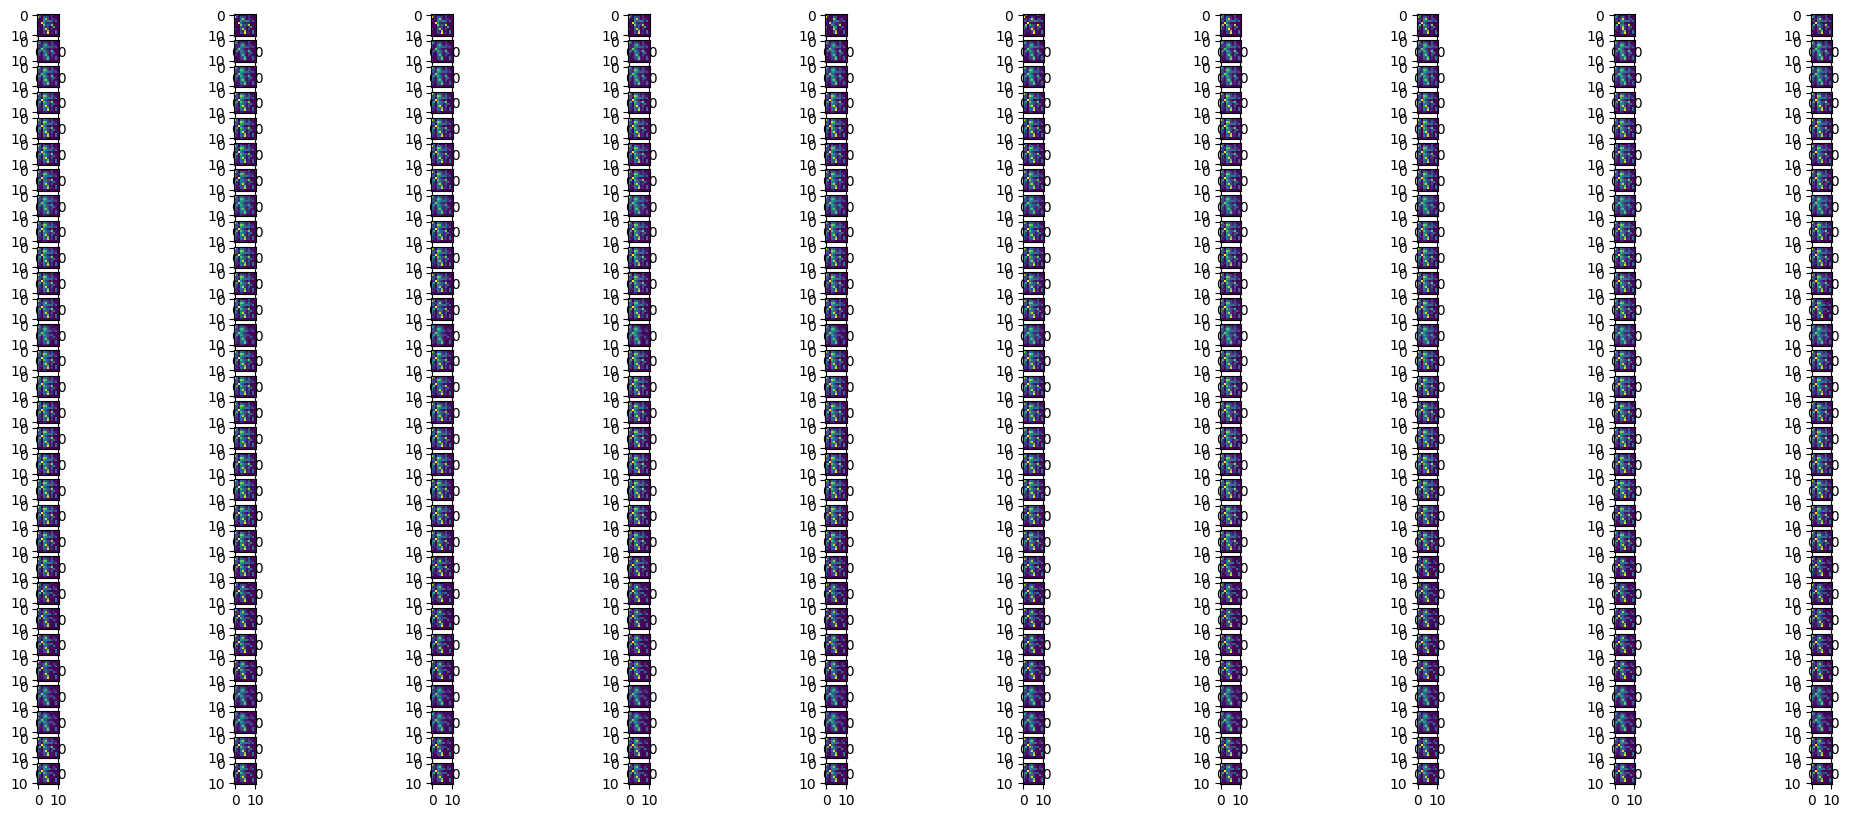

In [63]:
buffers2 = buffers
max_col = 32
max_row = 64
max_bytes = max_row * max_col
matrix = np.zeros((len(buffers2), max_row, max_col))

for i, buffer in enumerate(buffers2):
    pressure_sensor =buffer[2:2+max_bytes]
    matrix[i] = np.array(pressure_sensor).reshape(max_row, max_col)

df = pd.DataFrame(matrix.reshape(-1, 32).T)
df.to_csv("left_mid_300.csv")
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11].T)
        #plt.imshow(matrix[p-1, 1:12,:11].T)
        p += 1

In [64]:
import pandas as pd
import numpy as np
sensor_data_300 = pd.read_csv('left_mid_300.csv')
print(type(sensor_data_300))

<class 'pandas.core.frame.DataFrame'>


In [65]:
print(sensor_data_300)

    Unnamed: 0        0        1        2        3        4        5        6  \
0            0    735.0   9750.0    739.0   1414.0    760.0    748.0    727.0   
1            1  41077.0  10304.0    718.0  12919.0  10857.0   8070.0    968.0   
2            2   2048.0    718.0   1405.0  17008.0  37105.0   9663.0   1177.0   
3            3   6884.0    721.0    806.0  24657.0  13615.0  19907.0  19977.0   
4            4    803.0    730.0  43545.0  21205.0   6416.0   4728.0   5766.0   
5            5   2086.0   2272.0    919.0  35142.0   9082.0  14160.0   8087.0   
6            6    728.0    705.0    820.0  15144.0   6596.0  10127.0    906.0   
7            7  14850.0    720.0    710.0  14392.0  39723.0   8103.0   1031.0   
8            8    790.0    723.0    720.0  10325.0   3920.0  39497.0   1715.0   
9            9   2184.0    736.0    748.0  12240.0   6894.0  45782.0   3215.0   
10          10    736.0    729.0    734.0    769.0    764.0    740.0    768.0   
11          11    712.0    7

 ...]

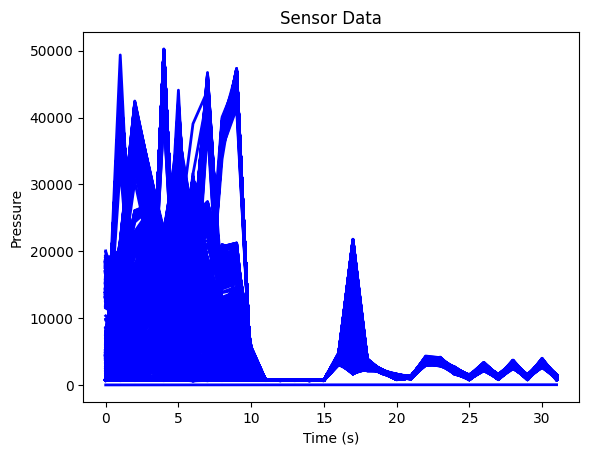

In [66]:
import matplotlib.pyplot as plt
import numpy as np

plt.title(' Sensor data')
# Add labels and a title
plt.xlabel('Time (s)')
plt.ylabel('Pressure')
plt.title('Sensor Data')
plt.plot(sensor_data_300, linewidth=2, linestyle="-", c="b")

In [20]:
import cv2
import numpy as np


# Convert the numpy array to cv2.UMat
sensor_CV_data = cv2.UMat(np.ascontiguousarray(sensor_data5))

# Resize the array to an 11x11 array
resized_CV_data = cv2.resize(sensor_CV_data, dsize=(11, 11), interpolation=cv2.INTER_LINEAR)

print(resized_CV_data)

#here it is resized using opencv 

< cv2.UMat 000002F16BA6EAF0>


In [43]:
#here it is resized using simple linear interpolation
reshaped_sensor_data5 = np.resize(sensor_data5, (11, 11))
np.savetxt("reshape_data.csv", reshaped_sensor_data5)

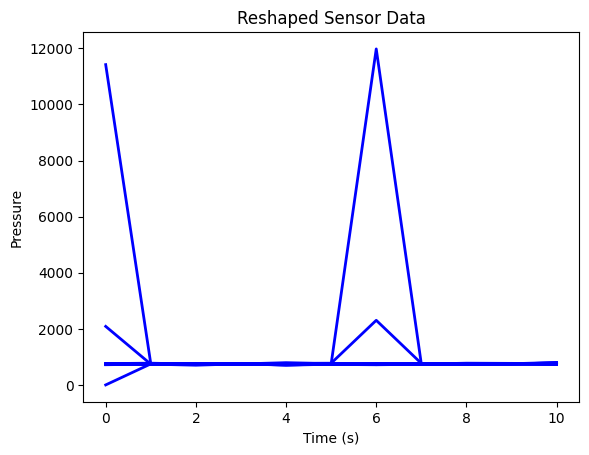

In [45]:
import matplotlib.pyplot as plt
import numpy as np

#plt.title(' same sensor data after reshaping')
plt.xlabel('Time (s)')
plt.ylabel('Pressure')
plt.title('Reshaped Sensor Data')

plt.plot(reshaped_sensor_data5, linewidth=2, linestyle="-", c="b")

<AxesSubplot: >

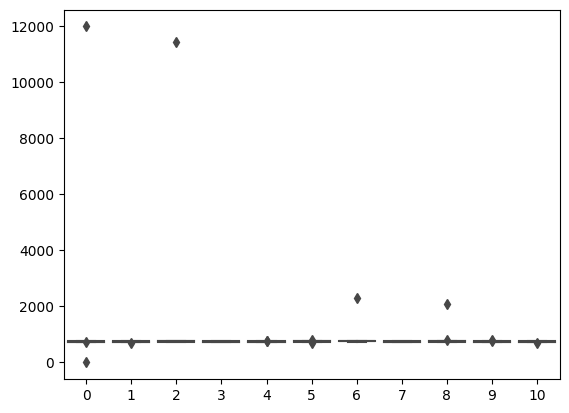

In [48]:
import seaborn as sns

# Create box plot
sns.boxplot(reshaped_sensor_data5)

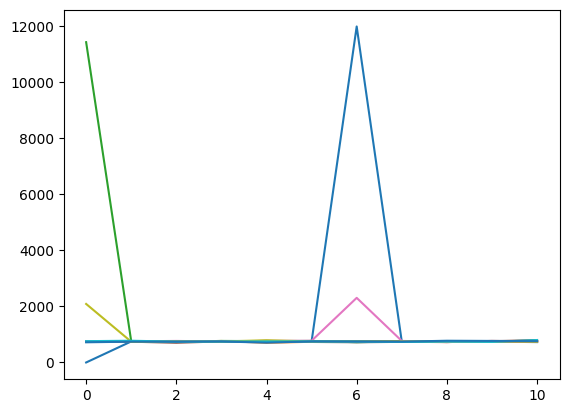

In [49]:
import matplotlib.pyplot as plt
plt.plot(reshaped_sensor_data5)

# Show the graph
plt.show()

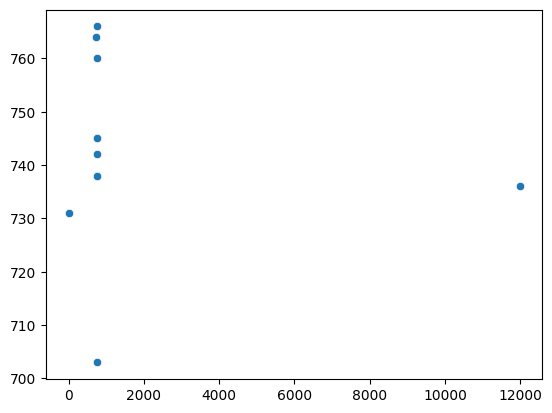

In [50]:
import seaborn as sns
import numpy as np



# Plot the sensor data
sns.scatterplot(x=reshaped_sensor_data5[:,0], y=reshaped_sensor_data5[:,1])

# Show the graph
plt.show()

In [55]:
import plotly.graph_objects as go
import pandas as pd

# Create some example sensor data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
z = pd.DataFrame(reshaped_sensor_data5)

# Plot the sensor data
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.show()

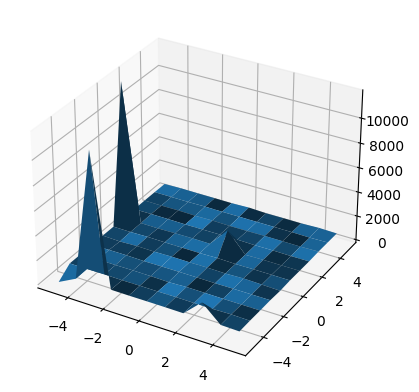

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create some example sensor data
x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
X, Y = np.meshgrid(x, y)
Z = pd.DataFrame(reshaped_sensor_data5)

# Create the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

# Show the plot
plt.show()

In [ ]:
import numpy as np

missing_values1 = np.isnan(reshaped_sensor_data)
print(missing_values1)

In [14]:
import numpy as np
import pandas as pd

df = pd.DataFrame(reshaped_sensor_data)

# Check for missing values
missing_values = df.isnull()

# Print the result
print(missing_values)


#reshaped_sensor_data.isnull().sum()
#the following code to check for missing or null values:

       0      1      2      3      4      5      6      7      8      9   \
0   False  False  False  False  False  False  False  False  False  False   
1   False  False  False  False  False  False  False  False  False  False   
2   False  False  False  False  False  False  False  False  False  False   
3   False  False  False  False  False  False  False  False  False  False   
4   False  False  False  False  False  False  False  False  False  False   
5   False  False  False  False  False  False  False  False  False  False   
6   False  False  False  False  False  False  False  False  False  False   
7   False  False  False  False  False  False  False  False  False  False   
8   False  False  False  False  False  False  False  False  False  False   
9   False  False  False  False  False  False  False  False  False  False   
10  False  False  False  False  False  False  False  False  False  False   

       10  
0   False  
1   False  
2   False  
3   False  
4   False  
5   False  
6  

In [80]:
import numpy as np
import pandas as pd

# Convert the numpy ndarray to a Pandas DataFrame
df = pd.DataFrame(sensor_data4, columns=['col1','col2','col3','col4','col5','col6','col7',
                                         'col8','col9','col10','col11','col12','col13','col14',
                                         'col15','col16','col17','col18','col19','col20','col21',
                                         'col22','col23','col24','col25','col26','col27','col28',
                                         'col29','col30','col31','col32'])

# Print the columns of the DataFrame
print(df.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9',
       'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17',
       'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25',
       'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32'],
      dtype='object')


In [76]:
df.columns.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [82]:
import pandas as pd


# Print the DataFrame with missing values
#print(df)

# convert object-dtype column 'C' to numeric using the `to_numeric()` function
df['col1'] = pd.to_numeric(df['col1'], errors='coerce')

# Print the DataFrame after converting 'Col1' column to numeric
print(df)

# fill in missing values using the interpolate() method
df = df.interpolate()

# Print the DataFrame with filled in missing values
print(df)

         col1     col2     col3     col4    col5     col6     col7    col8  \
0         0.0      1.0      2.0      3.0     4.0      5.0      6.0     7.0   
1       754.0  49407.0    767.0    735.0   704.0    745.0    863.0   806.0   
2     23102.0  11040.0  36018.0  40447.0  1543.0  25934.0  15644.0  6740.0   
3      1101.0    736.0    796.0    802.0   700.0    745.0    703.0   715.0   
4       744.0    728.0    760.0    710.0   726.0    727.0    701.0   726.0   
...       ...      ...      ...      ...     ...      ...      ...     ...   
1916    719.0    725.0    728.0    731.0   729.0    747.0    712.0   715.0   
1917    749.0    720.0    728.0    723.0   719.0    741.0    736.0   716.0   
1918    736.0    728.0    719.0    718.0   735.0    739.0    722.0   702.0   
1919    757.0    723.0    705.0    703.0   733.0    738.0    704.0   711.0   
1920    748.0    732.0    726.0    722.0   729.0    754.0    694.0   712.0   

        col9    col10  ...   col23   col24   col25   col26   co

<AxesSubplot: >

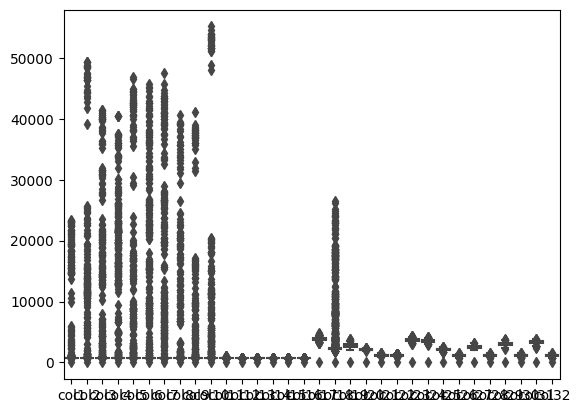

In [83]:
import seaborn as sns

# Create box plot
sns.boxplot(df)

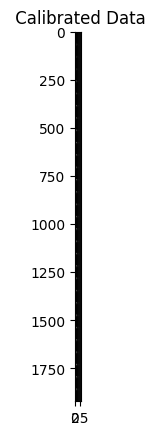

<Figure size 2500x1000 with 0 Axes>

In [ ]:
print(reshaped_sensor_data.columns)

In [64]:
import pandas as pd


# Print the DataFrame with missing values
print(reshaped_sensor_data)

# convert object-dtype column 'C' to numeric using the `to_numeric()` function
reshaped_sensor_data['A'] = pd.to_numeric(reshaped_sensor_data['A'], errors='coerce')

# Print the DataFrame after converting 'C' column to numeric
print(reshaped_sensor_data)

# fill in missing values using the interpolate() method
reshaped_sensor_data = reshaped_sensor_data.interpolate()

# Print the DataFrame with filled in missing values
print(reshaped_sensor_data)


# reshaped_sensor_data['A'] = reshaped_sensor_data['A'].astype(float)


# data = reshaped_sensor_data.apply(pd.to_numeric, errors='coerce')

    A
0 NaN
1 NaN
2 NaN
3 NaN
4 NaN
5 NaN
6 NaN
7 NaN
8 NaN
9 NaN
    A
0 NaN
1 NaN
2 NaN
3 NaN
4 NaN
5 NaN
6 NaN
7 NaN
8 NaN
9 NaN
    A
0 NaN
1 NaN
2 NaN
3 NaN
4 NaN
5 NaN
6 NaN
7 NaN
8 NaN
9 NaN


In [65]:
reshaped_sensor_data.interpolate()


#reshaped_sensor_data.fillna(reshaped_sensor_data.median())


,A
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


<AxesSubplot: >

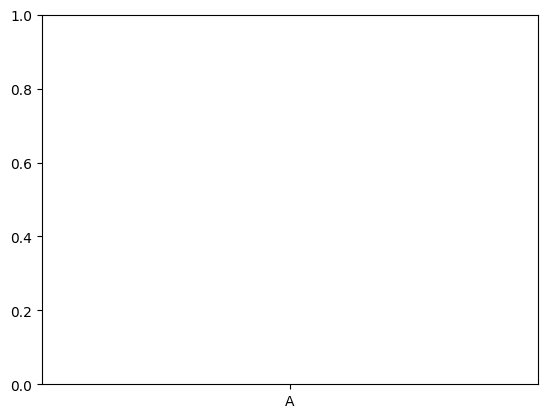

In [66]:
import seaborn as sns

# Create box plot
sns.boxplot(reshaped_sensor_data)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

plt.title(' Data')
reshaped_sensor_data = pd.read_csv('reshape_data.csv')
image = cv2.normalize(reshaped_sensor_data, None, 0, 1, cv2.NORM_MINMAX)
#plt.figure(figsize=(25, 10))
# Plot the data using Matplotlib's imshow function
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

plt.title(' Calibrated Data')
calibrated_data = pd.read_csv('calibrated_data2.csv')
#plt.figure(figsize=(25, 10))
# Plot the data using Matplotlib's imshow function
plt.imshow(calibrated_data, cmap='gray')
plt.show()

In [ ]:
sensor_data3 = pd.read_csv('test1.csv')

offset = 0.5
scale = 0.1

calibrated_data = (sensor_data3 - offset) * scale
np.savetxt("calibrated_data3.csv", calibrated_data)

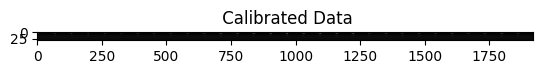

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.title(' Calibrated Data')
calibrated_data = pd.read_csv('calibrated_data2.csv')
#plt.figure(figsize=(25, 10))
# Plot the data using Matplotlib's imshow function
plt.imshow(calibrated_data, cmap='gray')
plt.show()

In [23]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# Read the .csv file into a pandas DataFrame
df = pd.read_csv('test1.csv')

# Extract the data for the first sensor

sensor1_data = df['0']

filtered_data = savgol_filter(sensor1_data, window_length=4, polyorder=2)



#..............Savitzky-Golay filter

In [24]:
print(filtered_data)


[ 2130.6    -1273.8    13759.625  13532.      -485.875    928.5
   581.375   1745.4375  1750.25     685.8125   783.0625   697.125
   695.       705.625    526.25    2262.25    2971.4375  2466.5625
  2565.9375  1497.3125   903.      2253.9375  3590.3125  2964.6875
  1538.875   1823.5625  1987.9375  2250.9375  2116.625   2127.6875
  1955.95    1650.35  ]


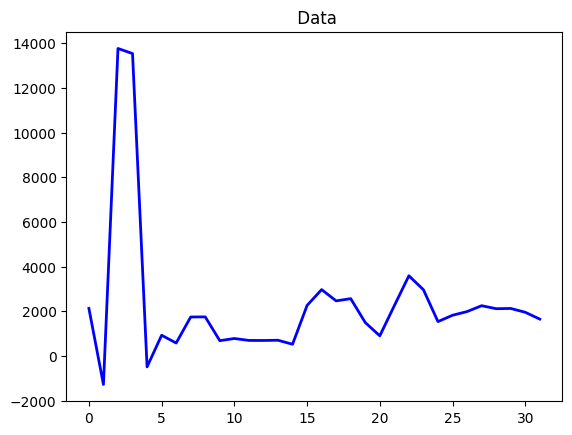

In [25]:

import matplotlib.pyplot as plt
import numpy as np

plt.title(' Data')
plt.plot(filtered_data, linewidth=2, linestyle="-", c="b")

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# Read the .csv file into a pandas DataFrame
df = pd.read_csv('test1.csv')

# Extract the data for the first sensor

sensor1_data = df['0']


# Define a function that applies normalization to the data
def normalize(data):
  return (data - np.mean(data)) / np.std(data)

# Apply the normalization function to the data
normalized_data = sensor1_data.apply(normalize)

# Calculate the mean and standard deviation of the normalized data
mean = np.mean(normalized_data)
std = np.std(normalized_data)


# Determine if the data is balanced
if abs(mean) < 0.1 and std < 0.2:
   print('Sensor 1 data is balanced')
else:
    print('Sensor 1 data is not balanced')

# Repeat the process for additional sensors as needed



#..................................apply preprocessing techniques...................normalization


In [74]:
print(normalized_data)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
Name: 0, dtype: float64


In [11]:
import pandas as pd
import numpy as np
from scipy import interpolate

# Read the .csv file into a pandas DataFrame
df = pd.read_csv('test1.csv')

# Extract the data for the first sensor

sensor1_data = df['0']

# Fit a spline to the data
x = np.arange(len(sensor1_data))
spline = interpolate.UnivariateSpline(x, sensor1_data, s=0.5)

# Smooth the data by evaluating the spline at a denser set of points
smooth_data = spline(np.linspace(0, len(sensor1_data)-1, num=len(sensor1_data)*10))

# The smooth_data variable now contains the data with noise removed




#.....You can adjust the smoothing parameter s to achieve the desired level of smoothing. A smaller value of s will result in a smoother curve, but may also overfit the data and remove important features..................


#........ spline fit ..............

In [12]:
print(smooth_data)

[  748.02182782  2936.52690958  4532.63087858  5596.30912511
  6187.53703945  6366.2900119   6192.54343275  5726.2726923
  5027.45318083  4156.06028865  3172.06940603  2135.45592328
  1106.19523069   144.26271855  -690.36622285 -1337.71620321
 -1737.81183225 -1830.67771966 -1556.33847517  -854.81870847
   333.85697073  2067.11230788  4313.64302875  6932.59834432
  9776.35405058 12697.28594353 15547.76981917 18180.18147349
 20446.89670249 22200.29130216 23292.74106851 23576.72837054
 22975.70487787 21606.91862339 19620.39383707 17166.15474888
 14394.22558879 11454.6305868   8497.39397285  5672.53997695
  3130.09282904  1020.07675912  -529.684709   -1536.48735783
 -2075.92782295 -2223.76063067 -2055.74030735 -1647.62137932
 -1075.15837291  -414.10581446   259.7817697    870.74985323
  1345.69747847  1660.64144402  1834.88795952  1889.22530109
  1844.44174484  1721.32556688  1540.66504332  1323.24845027
  1089.86406384   861.30016014   658.28314896   494.61923301
   370.96850527   286.520

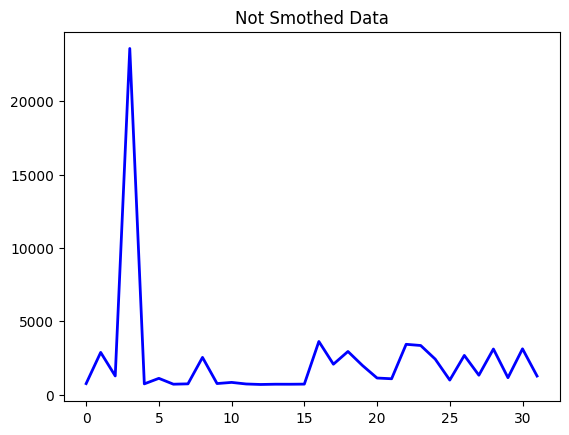

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Not Smothed Data')
plt.plot(sensor1_data, linewidth=2, linestyle="-", c="b")

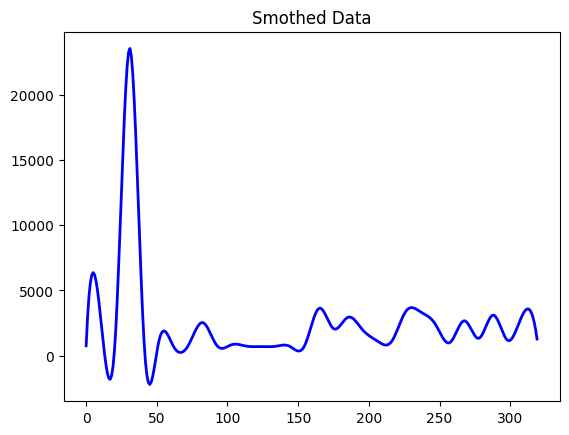

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Smothed Data')
plt.plot(smooth_data, linewidth=2, linestyle="-", c="b")

In [ ]:

# Read the .csv file into a pandas DataFrame
df = pd.read_csv('test1.csv')

# Extract the data for the first sensor

sensor1_data = df['0']

# Fit a spline to the data
x = np.arange(len(sensor1_data))
spline = interpolate.UnivariateSpline(x, sensor1_data, s=1)

# Smooth the data by evaluating the spline at a denser set of points
smooth_data = spline(np.linspace(0, len(sensor1_data)-1, num=len(sensor1_data)*10))

# The smooth_data variable now contains the data with noise removed




#.....You can adjust the smoothing parameter s to achieve the desired level of smoothing. A smaller value of s will result in a smoother curve, but may also overfit the data and remove important features..................


#........ spline fit ..............

In [49]:
df = pd.read_csv('test1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Columns: 1921 entries, Unnamed: 0 to 1919
dtypes: float64(1920), int64(1)
memory usage: 480.4 KB


In [52]:
import numpy as np


df = pd.read_csv('test1.csv')
# Extract the raw sensor data
sensor_data = df['0']

# Set the zero point and span values
zero_point = 0
span = 10

# Calculate the calibration coefficients
gain = span / (sensor_data.max() - sensor_data.min())
offset = zero_point - gain * sensor_data.min()

# Calculate the calibrated data
calibrated_data = gain * sensor_data + offset

# The calibrated_data variable now contains the calibrated sensor measurements


In [53]:
print(calibrated_data)


0      0.026197
1      0.954460
2      0.254552
3     10.000000
4      0.018338
5      0.182509
6      0.008296
7      0.018775
8      0.806008
9      0.027507
10     0.062001
11     0.014845
12     0.000000
13     0.007859
14     0.006986
15     0.010479
16     1.279308
17     0.603414
18     0.981967
19     0.564118
20     0.192115
21     0.170283
22     1.195477
23     1.160110
24     0.754486
25     0.130987
26     0.864952
27     0.275946
28     1.055757
29     0.201720
30     1.060996
31     0.251059
Name: 0, dtype: float64


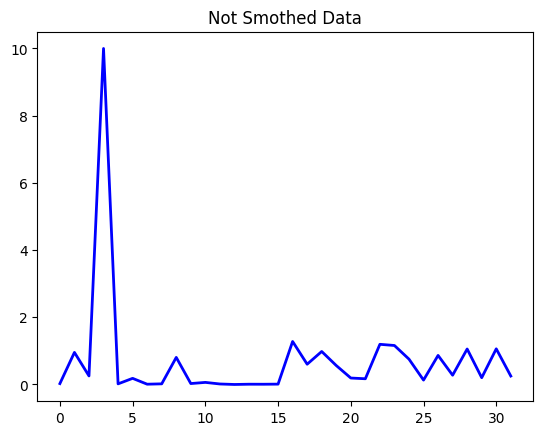

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Not Smothed Data')
plt.plot(calibrated_data, linewidth=2, linestyle="-", c="b")

In [45]:
print(df[:])

    Unnamed: 0        0        1        2        3        4        5        6  \
0            0    748.0  12852.0    762.0    767.0    738.0    761.0    750.0   
1            1   2874.0   5611.0    728.0   5942.0   5247.0  39559.0   6422.0   
2            2   1271.0  22022.0    853.0  31680.0  31573.0  12773.0   2303.0   
3            3  23591.0  11507.0    736.0  13329.0  11703.0  23616.0  27879.0   
4            4    730.0    729.0   1117.0    766.0    719.0    739.0    717.0   
5            5   1106.0  19144.0   1268.0   9011.0   4859.0  15892.0   6783.0   
6            6    707.0    944.0    714.0   7477.0   1648.0   1894.0    696.0   
7            7    731.0   6396.0  10404.0  30671.0   7250.0   4123.0   1000.0   
8            8   2534.0  16211.0    716.0   6053.0   5754.0  36852.0   3752.0   
9            9    751.0    753.0    746.0    795.0    760.0    780.0    744.0   
10          10    830.0   4323.0    735.0  31008.0   7304.0   8734.0    988.0   
11          11    722.0    7

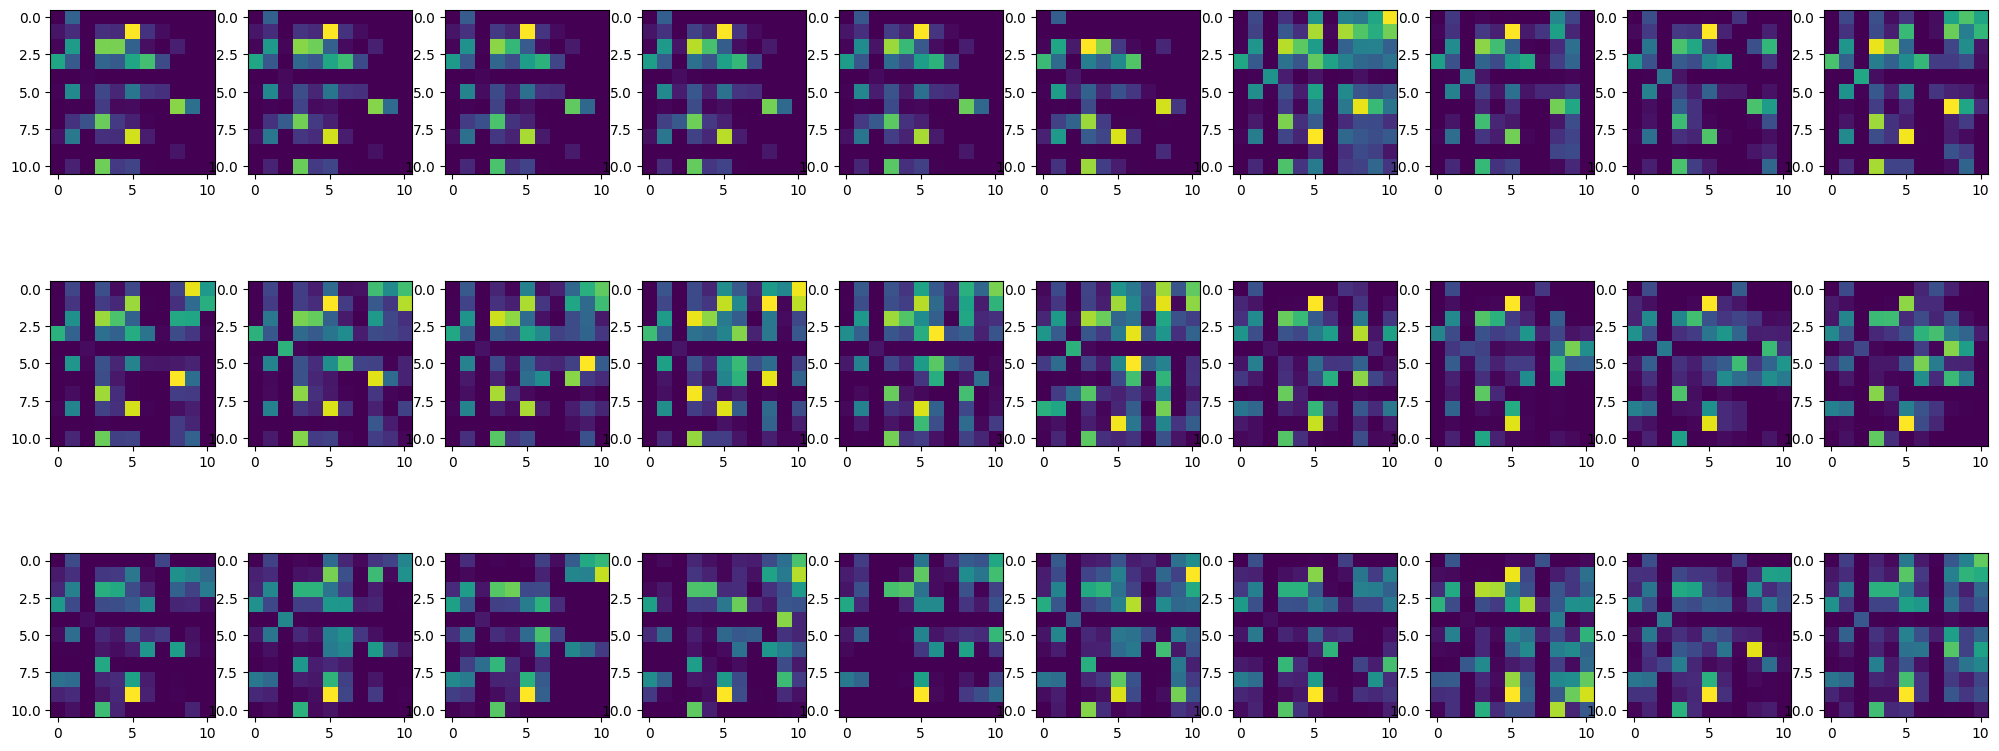

In [9]:
buffers2 = buffers
max_col = 32
max_row = 64
max_bytes = max_row * max_col
matrix = np.zeros((len(buffers2), max_row, max_col))

for i, buffer in enumerate(buffers2):
    pressure_sensor =buffer[2:2+max_bytes]
    matrix[i] = np.array(pressure_sensor).reshape(max_row, max_col)

df = pd.DataFrame(matrix.reshape(-1, 32).T)
df.to_csv("test1.csv")
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11].T)
        #plt.imshow(matrix[p-1, 1:12,:11].T)
        p += 1

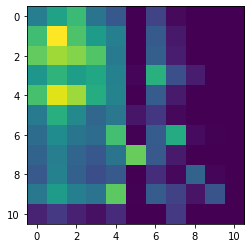

In [15]:
plt.imshow(matrix[10, 1:12,:11].T)

In [112]:
matrix[0, :11, :11]

array([[  888.,   733.,  1965., 17230.,   735.,   793.,   978.,   744.,
          737.,  7662.,   802.],
       [10146.,   741., 29286., 12373.,   870., 22244., 16365., 10666.,
         5311., 14376.,  6309.],
       [ 2230.,   730., 19967.,  9292.,   779., 18575., 14893.,  5511.,
        19523., 12676.,  5052.],
       [13900.,   721., 10366.,  2860.,   744.,  1993.,  1733.,  4296.,
          831.,  2015., 15496.],
       [  794.,   731.,  1289., 11057.,   742.,   763.,   929.,   764.,
          742.,  1434., 27929.],
       [ 8258.,   873., 24182., 17272., 10086., 11639., 28171., 12144.,
         9852., 33263., 14592.],
       [  748.,   732.,   844.,   771.,   742.,   779.,   736.,   864.,
          723.,   850.,  1197.],
       [  798.,   725.,  2880., 10751.,   737.,   894.,  3926.,  2857.,
         2380., 13747.,  2679.],
       [  793.,   726.,   770.,   890.,   752.,   768.,   895.,   742.,
        15554.,  2768.,  1038.],
       [ 1056.,   719., 10036., 13183.,  7375.,  6325.,

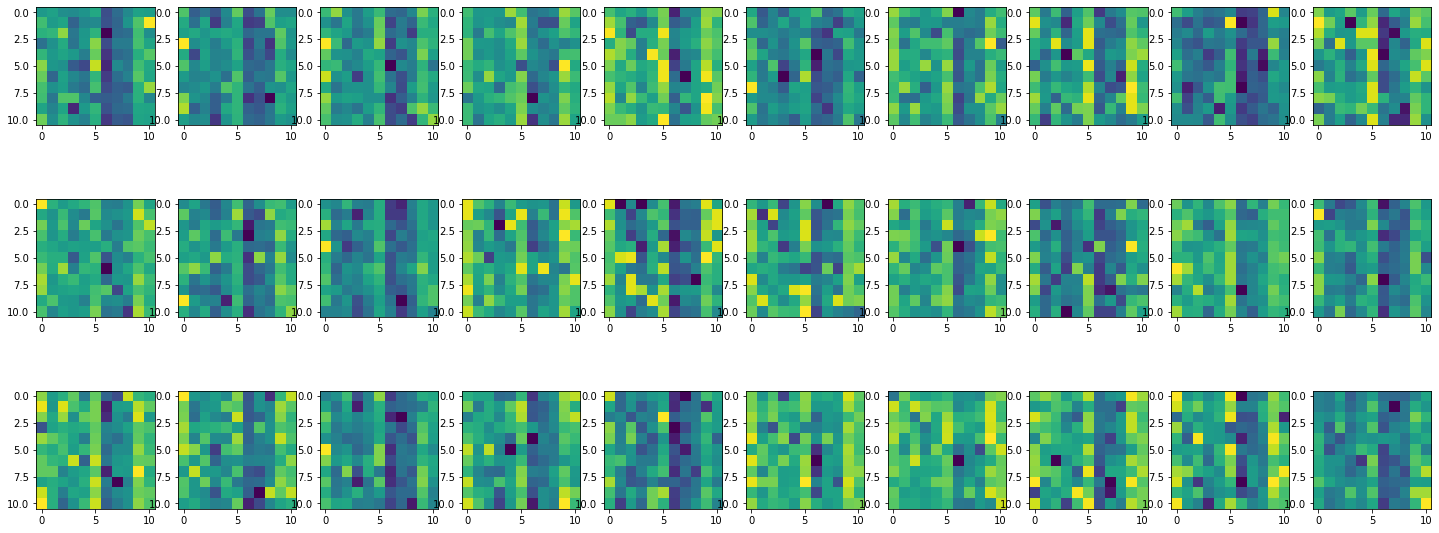

In [6]:
buffers1 = buffers
max_col = 32
max_row = 64
max_bytes = max_row * max_col
matrix = np.zeros((len(buffers1), max_row, max_col))

for i, buffer in enumerate(buffers1):
    pressure_sensor =buffer[2:2+max_bytes]
    matrix[i] = np.array(pressure_sensor).reshape(max_row, max_col)
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11])
        p += 1

In [53]:
df = pd.read_csv("balance_3.csv")

In [54]:
df = df.to_numpy()

In [55]:
df = df[:, 1:]
matrix = df.reshape(-1,64, 32)

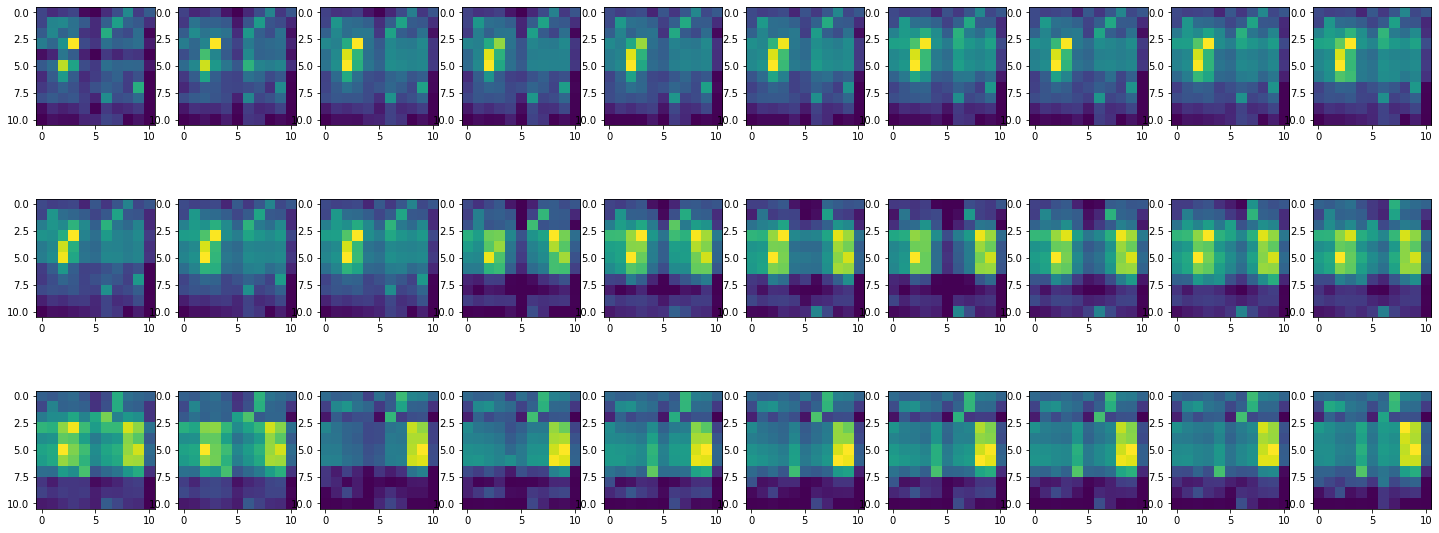

In [56]:
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11])
        p += 1